In [3]:
import tensorflow as tf
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
mnist = tf.keras.datasets.fashion_mnist
(X_train, _), (X_test, _) = mnist.load_data()

Each pixel intensity is represented as a byte (0 to 255); we scale it to 0-1 range and convert data to floats:

In [5]:
X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

Let's take a look at a sample of the images in the dataset:

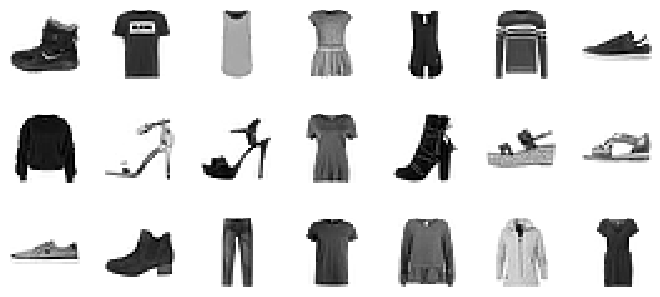

In [6]:
n_rows = 3
n_cols = 7
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [7]:
noise_factor = 0.2
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape) 
X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape) 

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)


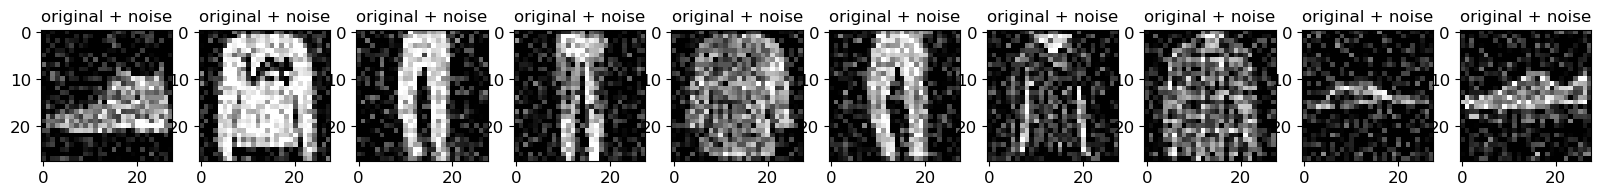

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.gray()
plt.show()


In [9]:
class ConvAutoencoder(tf.keras.models.Model):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = ConvAutoencoder()
autoencoder.compile(optimizer='adam', loss="bce")
autoencoder.fit(X_train_noisy, X_train, 
                epochs=20,
                shuffle=True,
                validation_data=(X_test, X_test),
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

autoencoder.summary()

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.3429 - val_loss: 0.2734
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.2718 - val_loss: 0.2729
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.2692 - val_loss: 0.2716
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2677 - val_loss: 0.2711
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2667 - val_loss: 0.2670
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2660 - val_loss: 0.2645
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2656 - val_loss: 0.2643
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.2653 - val_loss: 0.2639
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2651 - val_loss: 0.2635
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2649 - val_loss: 0.2632
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2648 - val_loss: 0.2633
Epoch 12/20
1875/1875 ━

Model: "conv_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 7, 7, 8)        │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 28, 28, 1)        │         1,897 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,653 (37.71 KB)

 Trainable params: 3,217 (12.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,436 (25.14 KB)

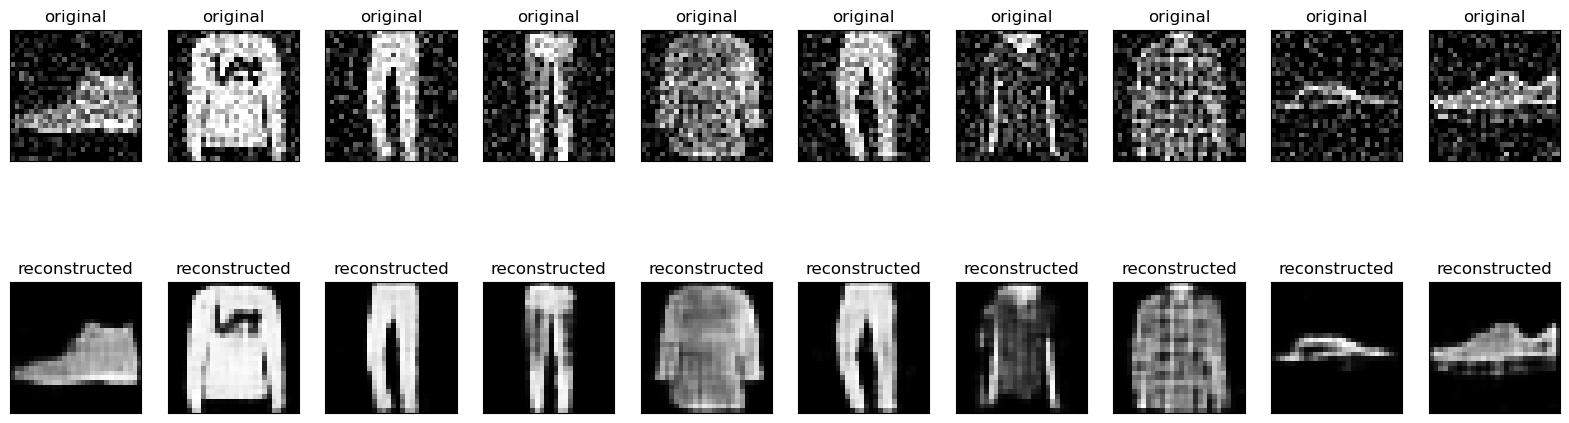

In [10]:
encoded_imgs = autoencoder.encoder(X_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test_noisy[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
